In [1]:
try:
    #!rm foolsunet_imagenette.weights.h5
    passes += 1
    #!git stash
    !git pull --force
except:
    passes = 1
    !git clone https://github.com/arminwitte/FoolsUNet.git
    %cd FoolsUNet
    !git pull --force

Cloning into 'FoolsUNet'...
remote: Enumerating objects: 739, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 739 (delta 109), reused 2 (delta 2), pack-reused 564 (from 1)
Receiving objects: 100% (739/739), 112.87 MiB | 40.13 MiB/s, done.
Resolving deltas: 100% (447/447), done.
Updating files: 100% (41/41), done.
/kaggle/working/FoolsUNet
Already up to date.


In [2]:
import tensorflow as tf

print(tf.__version__)

2024-10-01 20:31:40.713115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 20:31:40.713217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 20:31:40.845744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))

In [4]:
import tensorflow_datasets as tfds

In [5]:
dataset, info = tfds.load("imagenette/320px-v2:1.*.*", with_info=True, data_dir="./data/")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteHEXPNK/imagenette-train.tfrecord*...:   0%|          | 0/94…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteHEXPNK/imagenette-validation.tfrecord*...:   0%|          |…

Dataset imagenette downloaded and prepared to ./data/imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


In [6]:
dataset

{Split('train'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [8]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (256, 256))
    input_label = datapoint["label"]

    input_image = normalize(input_image)

    return input_image, input_label

In [9]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = TRAIN_LENGTH
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(f"train length: {TRAIN_LENGTH}")
print(f"train length: {TRAIN_LENGTH / BATCH_SIZE}")
print(f"train length: {STEPS_PER_EPOCH}")

train length: 9469
train length: 147.953125
train length: 147


In [10]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import layers
class Augment(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [12]:
train_batches = (
    train_images.cache()
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

## Get pre-trained encoder and attach classification head

In [13]:
from foolsunet.model import foolsunet, encoder, classification_head

In [14]:
num_classes = 10

In [15]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
    # base_model_1 = tf.keras.models.load_model("foolsunet_imagenet_resized_6-9_epoch.keras")
    # base_model_2 = foolsunet(channel_attention="eca")
    # base_model_1.summary()
    enc = encoder(channel_attention="eca")
    print(enc.output_shape)
    head = classification_head(num_classes, input_shape=enc.output_shape[1:])
    

(None, 8, 8, 256)


In [16]:
def assemble_model():
    model = tf.keras.Sequential(enc.layers + [head,])
    # model = tf.keras.Sequential([enc,head])
    model.build()
    return model 

In [17]:
with strategy.scope():
    model = assemble_model()
    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(
    optimizer=opt,
    #Anything between 2 and `steps_per_epoch` could help here.
    #steps_per_execution = 50,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
    model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ stage_0_downsample (Conv2D)     │ (None, 128, 128, 24)   │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_1_conv_0                  │ (None, 128, 128, 24)   │         5,956 │
│ (FusedMBConvBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_1_aspp_1 (FusedASPPBlock) │ (None, 128, 128, 24)   │        20,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_2_conv_0                  │ (None, 64, 64, 48)     │        51,652 │
│ (FusedMBConvBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_2_aspp_1 (ASPPBlock)      │ (None, 64, 64, 48)     │        26,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_3_conv_0                  │ (None, 32, 32, 64)     │       128,260 │
│ (FusedMBConvBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_3_aspp_1 (ASPPBlock)      │ (None, 32, 32, 64)     │        45,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_4_conv_0                  │ (None, 16, 16, 128)    │       107,524 │
│ (InverseResidualBlock)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_4_aspp_1 (ASPPBlock)      │ (None, 16, 16, 128)    │       172,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_5_conv_0                  │ (None, 16, 16, 160)    │       293,444 │
│ (InverseResidualBlock)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_5_aspp_1 (ASPPBlock)      │ (None, 16, 16, 160)    │       266,884 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_6_conv_0                  │ (None, 8, 8, 256)      │       666,116 │
│ (InverseResidualBlock)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_6_aspp_1 (ASPPBlock)      │ (None, 8, 8, 256)      │       672,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 10)             │       346,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,804,578 (10.70 MB)

 Trainable params: 2,774,226 (10.58 MB)

 Non-trainable params: 30,352 (118.56 KB)

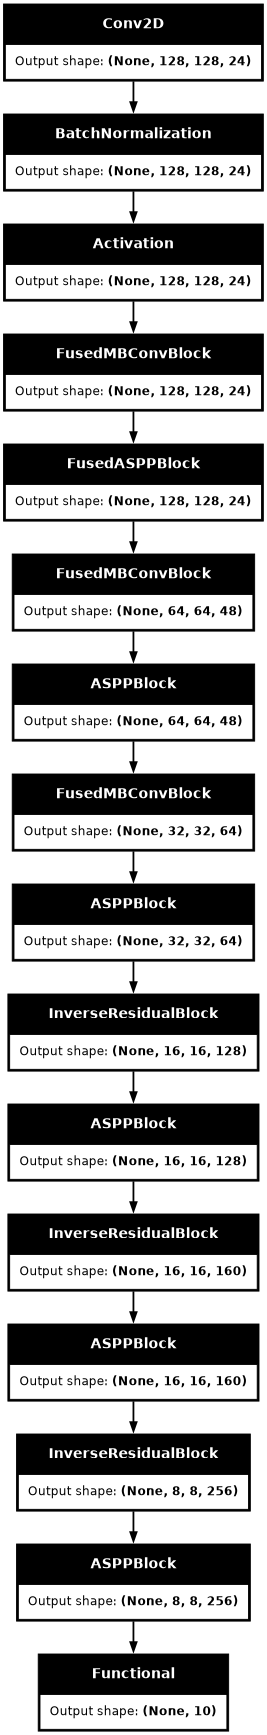

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [19]:
EPOCHS = 100
VAL_SUBSPLITS = 1
VALIDATION_STEPS = info.splits["validation"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    # callbacks=[DisplayCallback()]
    # callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, start_from_epoch=10)],
)

Epoch 1/100


2024-10-01 20:33:21.776930: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/stage_1_aspp_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 ━━━━━━━━━━━━━━━━━━━━ 173s 803ms/step - accuracy: 0.2253 - loss: 2.4494 - val_accuracy: 0.0999 - val_loss: 2.7022
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 106s 723ms/step - accuracy: 0.4530 - loss: 1.6205 - val_accuracy: 0.2857 - val_loss: 2.0381
Epoch 3/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 775ms/step - accuracy: 0.5924 - loss: 1.2354 - val_accuracy: 0.3414 - val_loss: 2.0497
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 105s 713ms/step - accuracy: 0.6752 - loss: 0.9904 - val_accuracy: 0.4762 - val_loss: 2.2838
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 775ms/step - accuracy: 0.7179 - loss: 0.8514 - val_accuracy: 0.5651 - val_loss: 1.7435
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 105s 712ms/step - accuracy: 0.7683 - loss: 0.7156 - val_accuracy: 0.7143 - val_loss: 1.1849
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 774ms/step - accuracy: 0.7959 - loss: 0.6328 - val_accuracy: 0.5791 - val_loss: 1.8011
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 105s 712ms/step - accuracy: 0.8026 - loss: 0.5994 - val_accuracy: 0.5714 - val_loss: 2.0125
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 114s 774ms/step - accuracy: 0.8211 - loss: 0.5565 - val_accuracy: 0.7093 - val_loss: 1.0304
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 105s 713ms/step - accuracy: 0.8453 - lo

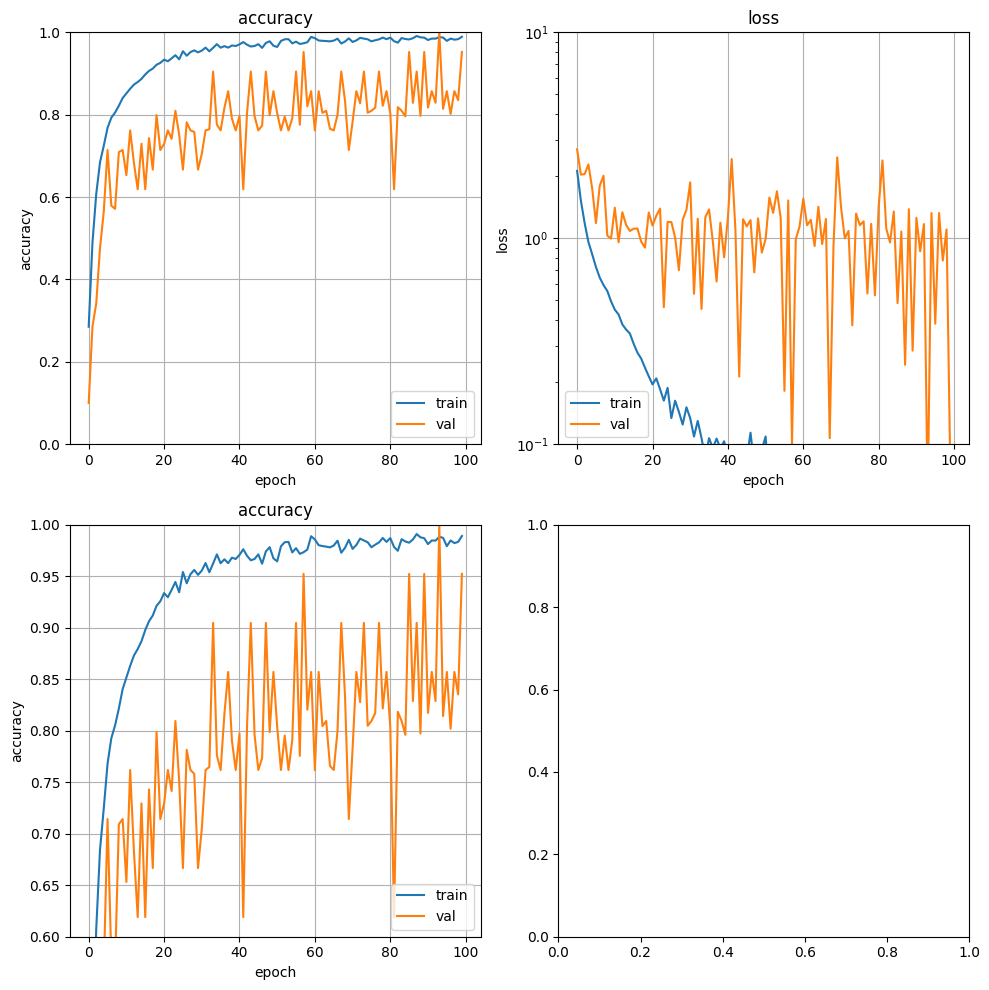

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].plot(model_history.history["accuracy"])
ax[0, 0].plot(model_history.history["val_accuracy"])
ax[0, 0].set_title("accuracy")
ax[0, 0].set_ylabel("accuracy")
ax[0, 0].set_xlabel("epoch")
ax[0, 0].set_ylim(0.0,1.0)
ax[0, 0].legend(["train", "val"], loc="lower right")
ax[0, 0].grid()


ax[0, 1].plot(model_history.history["loss"])
ax[0, 1].plot(model_history.history["val_loss"])
ax[0, 1].set_yscale("log")
ax[0, 1].set_title("loss")
ax[0, 1].set_ylabel("loss")
ax[0, 1].set_xlabel("epoch")
ax[0, 1].set_ylim(0.1,10.0)
ax[0, 1].legend(["train", "val"], loc="lower left")
ax[0, 1].grid()

ax[1, 0].plot(model_history.history["accuracy"])
ax[1, 0].plot(model_history.history["val_accuracy"])
ax[1, 0].set_title("accuracy")
ax[1, 0].set_ylabel("accuracy")
ax[1, 0].set_xlabel("epoch")
ax[1, 0].set_ylim(0.6,1.0)
ax[1, 0].legend(["train", "val"], loc="lower right")
ax[1, 0].grid()

fig.tight_layout()

In [21]:
# Save the entire model as a `.keras` zip archive.
model.save("foolsunet_imagenette.keras")

In [22]:

model.save_weights("foolsunet_imagenette.weights.h5")

In [23]:
new_model = tf.keras.models.load_model("foolsunet_imagenette.keras")

# Show the model architecture
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ stage_0_downsample (Conv2D)     │ (None, 128, 128, 24)   │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_1_conv_0                  │ (None, 128, 128, 24)   │         5,956 │
│ (FusedMBConvBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_1_aspp_1 (FusedASPPBlock) │ (None, 128, 128, 24)   │        20,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_2_conv_0                  │ (None, 64, 64, 48)     │        51,652 │
│ (FusedMBConvBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_2_aspp_1 (ASPPBlock)      │ (None, 64, 64, 48)     │        26,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_3_conv_0                  │ (None, 32, 32, 64)     │       128,260 │
│ (FusedMBConvBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_3_aspp_1 (ASPPBlock)      │ (None, 32, 32, 64)     │        45,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_4_conv_0                  │ (None, 16, 16, 128)    │       107,524 │
│ (InverseResidualBlock)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_4_aspp_1 (ASPPBlock)      │ (None, 16, 16, 128)    │       172,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_5_conv_0                  │ (None, 16, 16, 160)    │       293,444 │
│ (InverseResidualBlock)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_5_aspp_1 (ASPPBlock)      │ (None, 16, 16, 160)    │       266,884 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_6_conv_0                  │ (None, 8, 8, 256)      │       666,116 │
│ (InverseResidualBlock)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage_6_aspp_1 (ASPPBlock)      │ (None, 8, 8, 256)      │       672,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 10)             │       346,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353,032 (31.86 MB)

 Trainable params: 2,774,226 (10.58 MB)

 Non-trainable params: 30,352 (118.56 KB)

 Optimizer params: 5,548,454 (21.17 MB)